## Understanding Melbourne Suburbs: Location Prediction with XGBoost and Advanced Cluster Analysis with Gaussian Mixture Models

Melbourne has experienced a vast housing market bubble which recently cooled off.
The Australian definition of a "suburb" is more what we'd call a "neighborhood" in the US. This dataset lists over 350 "suburbs" of Melbourne.

In this project I'll attempt to understand what makes a neighborhood "hot," through clustering and understanding each cluster.
Then I'll attempt to predict *where a house is* based on the important features. This is useful to marketers who work with GIS data and may want to understand each region.

This dataset is from Kaggle.


In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.3)
%matplotlib inline

In [2]:
df=pd.read_csv('Melbourne_housing.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Regionname,Propertycount
0,Glen Iris,1/58 Edgar St N,2,t,600000.0,VB,Gary,2016-08-22,9.2,3146,2.0,1.0,1.0,0.0,1143.0,NaN,Boroondara City Council,Southern Metropolitan,10412.0
1,Essendon,118 Buckley St,3,h,1100000.0,PI,Raine,2016-08-28,8.0,3040,3.0,1.0,2.0,0.0,700.0,1915.0,Moonee Valley City Council,Western Metropolitan,9264.0
2,Port Melbourne,801/65 Beach St,3,u,2260000.0,S,Marshall,2016-05-22,3.8,3207,3.0,2.0,2.0,0.0,450.0,NaN,Melbourne City Council,Southern Metropolitan,8648.0
3,Strathmore,69 Lloyd St,4,h,1635000.0,S,Considine,2017-02-11,9.7,3041,4.0,2.0,3.0,0.0,297.0,1995.0,Moonee Valley City Council,Western Metropolitan,3284.0
4,Toorak,7a Woorigoleen Rd,3,t,2650000.0,VB,Jellis,2016-09-10,4.6,3142,3.0,3.0,2.0,0.0,291.0,2000.0,Stonnington City Council,Southern Metropolitan,7217.0


In [3]:
#Investigating class weights
df['Type'].value_counts()

h    23961
u     7296
t     3578
Name: Type, dtype: int64

The dataset is fairly clean, except for a large # of observations with a Landsize or BuildingArea of 0. I'll remove large outliers but not log-transform the columns because of the 0-values.

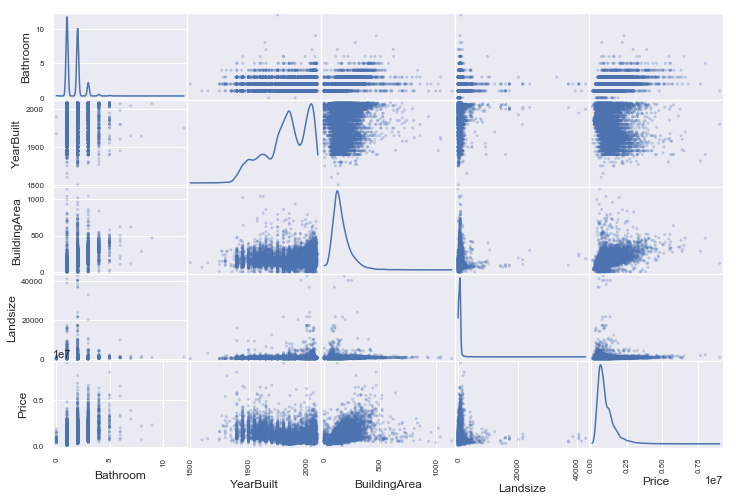

In [4]:
pd.plotting.scatter_matrix(df[['Bathroom','YearBuilt', 'BuildingArea','Landsize', 'Price']], alpha = 0.3,figsize = (12,8), diagonal = 'kde');
#There are some observations to be cleaned here.

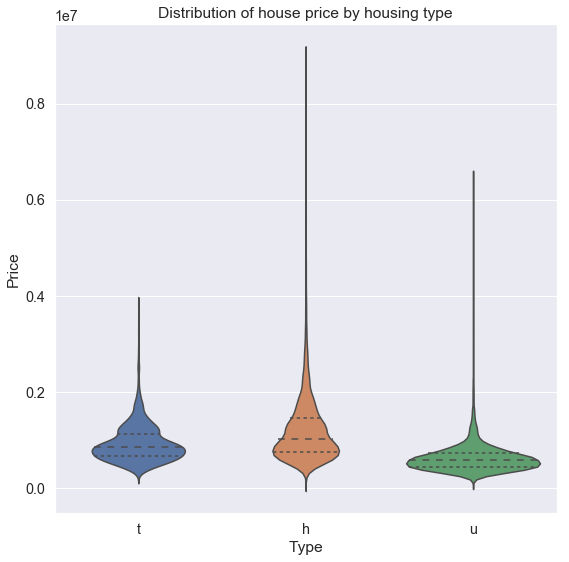

In [91]:
df2=df[['Price','Type', 'Distance']]
df2=df2.dropna()
plt.figure(figsize=(9,9))
sns.violinplot(x=df2['Type'],y=df2['Price'], inner='quartile')
plt.title("Distribution of house price by housing type")
plt.show()
#All types of housing are extremely right-skewed: 
#Observations are mostly at the lower end of the price, but there are enough that I won't omit them.

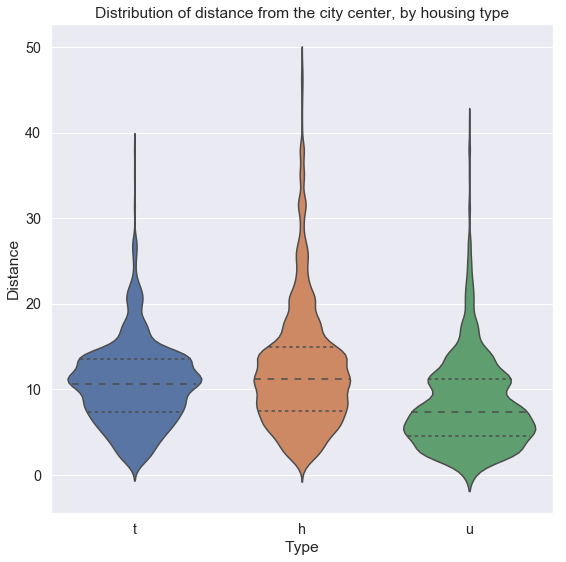

In [93]:
plt.figure(figsize=(9,9))
sns.violinplot(x="Type", y="Distance", data=df2, inner='quartile')
plt.title("Distribution of distance from the city center, by housing type")
plt.show()
#Notably, there's 

In [5]:
#Create new dataframe of aggregate values for each suburb
med_price = pd.DataFrame(df.groupby('Suburb')['Price'].agg(np.mean), columns=['Suburb','Price'])
med_distance = pd.DataFrame(df.groupby('Suburb')['Distance'].agg(np.mean), columns=['Suburb','Distance'])
med_lot = pd.DataFrame(df.groupby('Suburb')['Landsize'].agg(np.mean), columns=['Suburb','Landsize'])
med_year= pd.DataFrame(df.groupby('Suburb')['YearBuilt'].agg(np.mean), columns=['Suburb','YearBuilt'])
med_sqft=pd.DataFrame(df.groupby('Suburb')['BuildingArea'].agg(np.mean), columns=['Suburb','BuildingArea'])
med_car=pd.DataFrame(df.groupby('Suburb')['Car'].agg(np.mean), columns=['Suburb','Car'])
med_bath=pd.DataFrame(df.groupby('Suburb')['Bathroom'].agg(np.mean), columns=['Suburb','Bathroom'])

burbs=df['Suburb'].unique()
print(len(burbs))

349


In [6]:
from pandas import DataFrame
subdf= DataFrame()
subdf['Price']=med_price.Price
subdf['Distance']= med_distance.Distance
subdf['Lot Size']= med_lot.Landsize
subdf['Year']=med_year.YearBuilt
subdf['SqFt']=med_sqft.BuildingArea
subdf['Car']= med_car.Car
subdf['Bathroom']=med_bath.Bathroom
subdf['Suburb']=burbs
subdf=subdf.dropna()
print(subdf.head())

                     Price   Distance    Lot Size         Year        SqFt  \
Suburb                                                                       
Abbotsford    1.033549e+06   2.715328  354.279070  1942.545455  103.610169   
Aberfeldie    1.307193e+06   8.340000  536.919355  1978.295455  185.206216   
Airport West  7.513642e+05  11.835185  453.225490  1983.661538  137.158814   
Albanvale     5.360556e+05  14.000000  527.800000  1980.666667  127.375000   
Albert Park   1.927651e+06   3.178626  198.227273  1910.206349  136.921053   

                   Car  Bathroom          Suburb  
Suburb                                            
Abbotsford    1.033708  1.422680       Glen Iris  
Aberfeldie    1.940299  1.895522        Essendon  
Airport West  1.642202  1.504587  Port Melbourne  
Albanvale     2.153846  1.500000      Strathmore  
Albert Park   0.757009  1.595041          Toorak  


In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

#Putting in all numeric features that make any sense, to start

X= subdf[['Lot Size','Year','SqFt','Distance','Price', 'Car', 'Bathroom']]
data = pd.DataFrame(scale(X), columns=['Lot Size','Year','SqFt','Distance','Price', 'Car', 'Bathroom'])

pca = PCA(n_components=4).fit(data)
pca_samples= pca.transform(data)
print(data.head())

   Lot Size      Year      SqFt  Distance     Price       Car  Bathroom
0 -0.198902 -1.556636 -1.419308 -1.358748  0.291102 -1.698517 -0.888238
1 -0.133503  0.199615  0.553776 -0.808015  1.075663  0.162348  0.704915
2 -0.163472  0.463229 -0.608064 -0.465789 -0.517947 -0.449524 -0.612268
3 -0.136768  0.316103 -0.844648 -0.253824 -1.135256  0.600675 -0.627724
4 -0.254782 -3.145324 -0.613814 -1.313384  2.854570 -2.266467 -0.307500


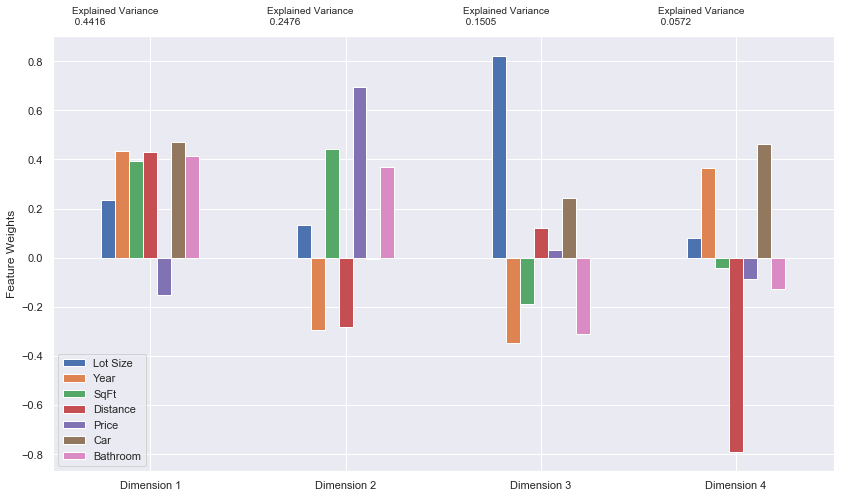

In [8]:
def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca_results = pca_results(data, pca)

In [9]:
#Examining the values charted above:
pca_results.cumsum()

,Explained Variance,Lot Size,Year,SqFt,Distance,Price,Car,Bathroom
Dimension 1,0.4416,0.2356,0.4359,0.3949,0.4289,-0.1514,0.4708,0.4122
Dimension 2,0.6892,0.3680,0.1393,0.8386,0.1447,0.5424,0.4666,0.7804
Dimension 3,0.8397,1.1887,-0.2065,0.6484,0.2645,0.5750,0.7091,0.4697
Dimension 4,0.8969,1.2669,0.1574,0.6067,-0.5251,0.4888,1.1704,0.3433


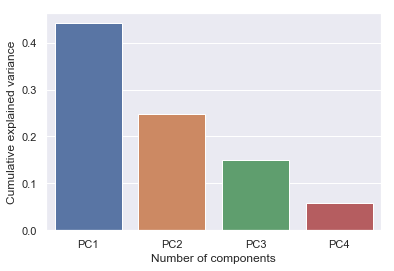

In [10]:
dfvar = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4']})
sns.barplot(x='PC',y="var",  
           data=dfvar);
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [11]:
pca = PCA(n_components=2).fit(data)
reduced_data = pca.transform(data)
pca_samples = pca.transform(data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [12]:
def biplot(data, reduced_data, pca):
    
    fig, ax = plt.subplots(figsize = (14,8))
    
    # scatterplot of the reduced data 
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # using scaling factors to make the arrows
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, data.columns[i], color='black', ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax


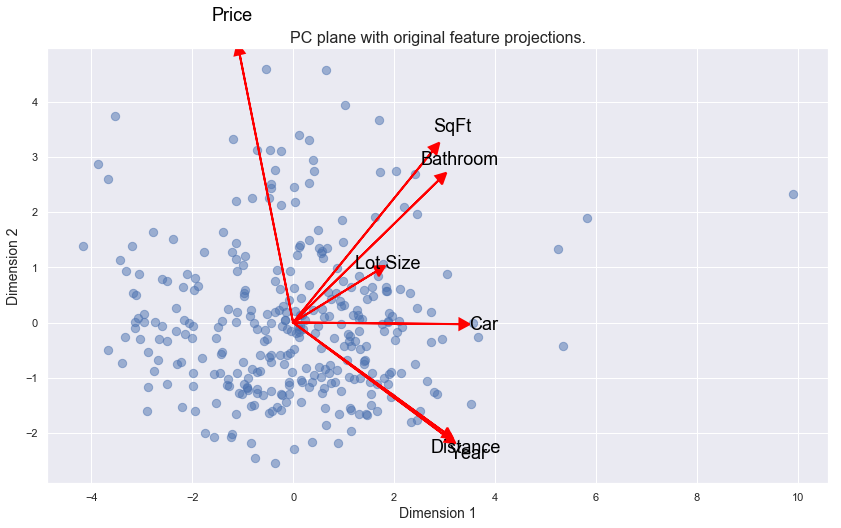

In [12]:
biplot(data, reduced_data, pca)

## Interpreting the Biplot

So we got the biplot function to work. Each vector on a biplot is the loading scores of the first 2 principal components for that feature.
If two features are right next to each other, like Lot Size and SqFt, it means they're strongly correlated. Including both Lot Size and SqFt in a machine learning model would be redundant.

If two features are pointing in the opposite direction, they're negatively correlated. A high 'Year' value (meaning) a newer house, is *strongly* negatively correlated with a high price.

### Important: length of the vectors
Notice 'Price', 'Distance' and 'Year' have very long loading vectors. It indicates a large weight in the first principal component score. See the bar chart above.
'Lot Size' doesn't appear to be as influential as other features, and it's highly correlated with 'Car' and 'SqFt'. I'll drop it from my model.

### Direction of vectors
'Car' would, at first glance, seem to be a great variable to include in a machine learning or clustering model: its loading has a respectable length and it's not heavily correlated with anything else. But it explains almost nothing in the 2nd principal component. As we'll see, including it in the model is not helpful.

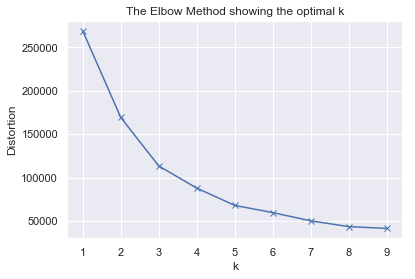

In [13]:
#Determine k using elbow method with KMeans

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## With lack of a distinct "elbow," I'll need to use silhouette scores to determine # of clusters.
The silhouette score is a measure of an observation's similarity to other members of the same cluster.
### Benchmarking with Agglomerative (hierarchical) clustering

For n_clusters = 2 The average silhouette_score is : 0.3881793936400056
For n_clusters = 3 The average silhouette_score is : 0.3451268065823988
For n_clusters = 4 The average silhouette_score is : 0.30471399116256653
For n_clusters = 5 The average silhouette_score is : 0.28532489721201054


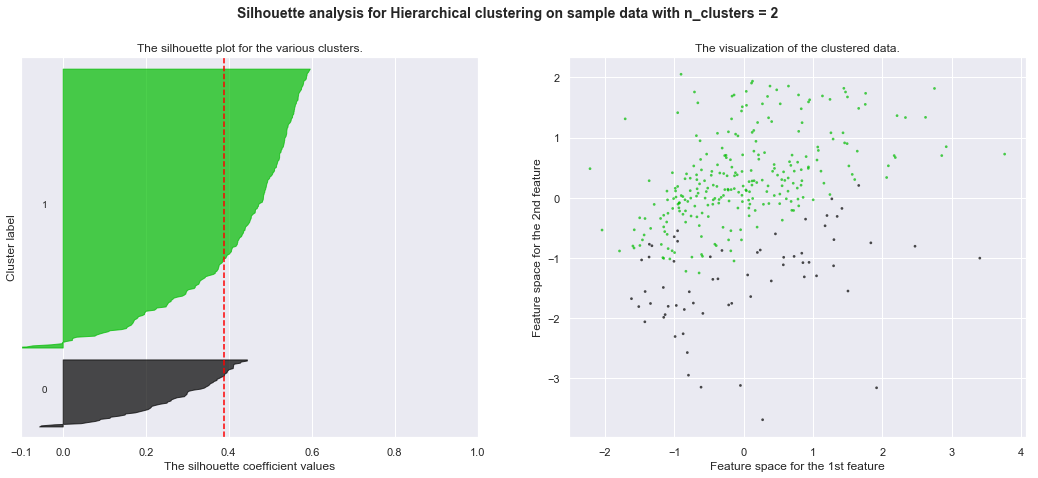

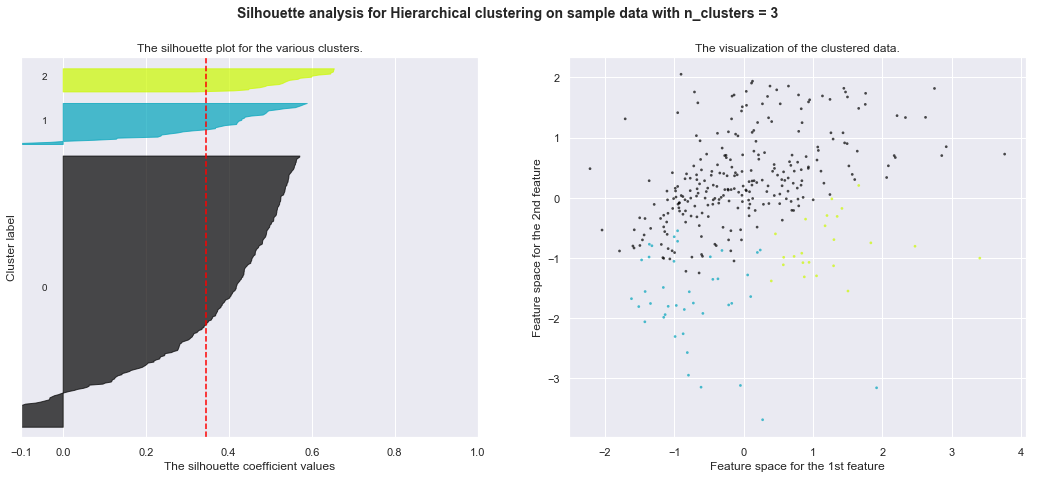

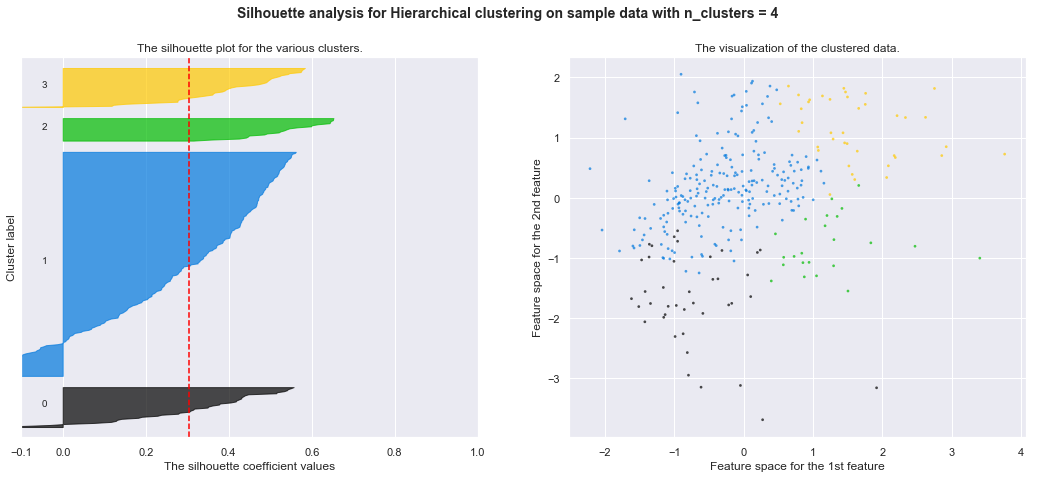

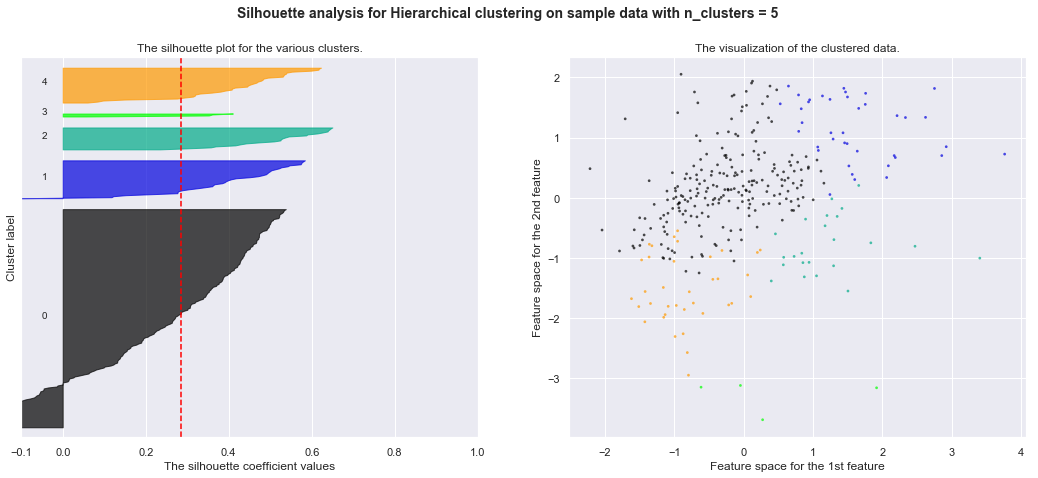

In [15]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering as AC
import matplotlib.cm as cm

Z= np.array(data[['SqFt','Year', 'Price']]).reshape(-1, 3)

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Z) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AC(n_clusters=n_clusters, linkage = 'complete')
    cluster_labels = clusterer.fit_predict(Z)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Z, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Z, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Z[:, 0], Z[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for Hierarchical clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## I'll try another clustering method, the Gaussian Mixture Model.

Choosing the number of clusters is up to you, and not every dataset in the world exhibits clustering. However, I'm not entirely satisfied with this silhouette score, 34.5%. Let's see if a Gaussian Mixture Model can improve cluster quality.

For n_clusters = 2 The average silhouette_score is : 0.4017988688255937
For n_clusters = 3 The average silhouette_score is : 0.2420624243960161
For n_clusters = 4 The average silhouette_score is : 0.3788979741225438
For n_clusters = 5 The average silhouette_score is : 0.30075672657715385


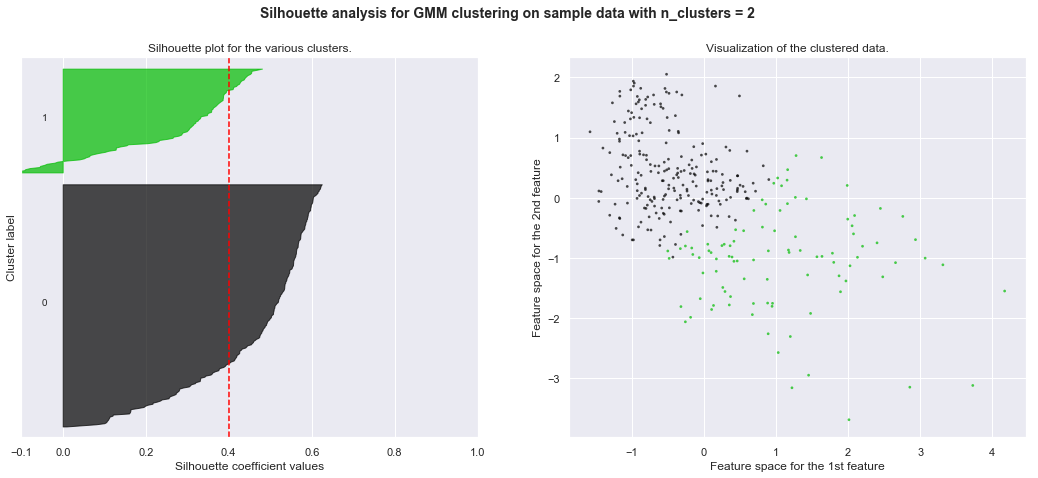

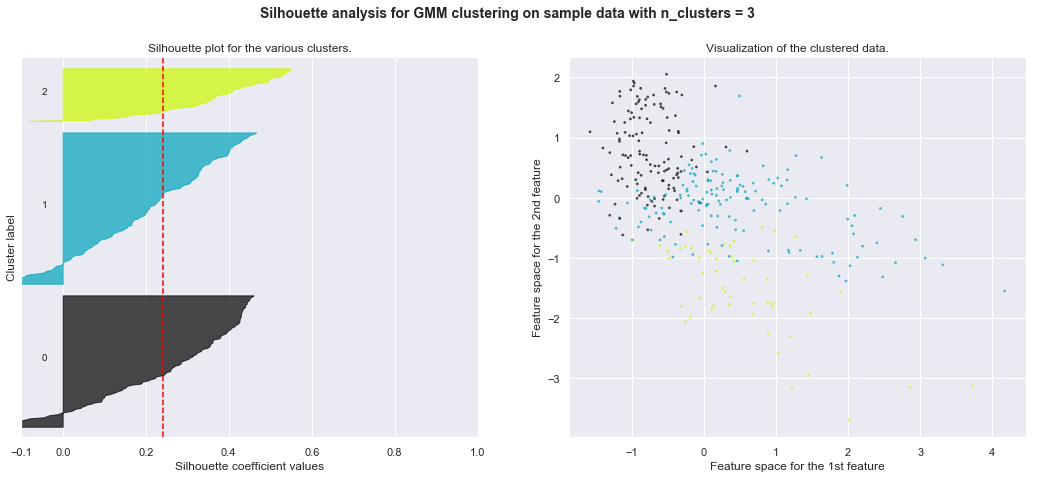

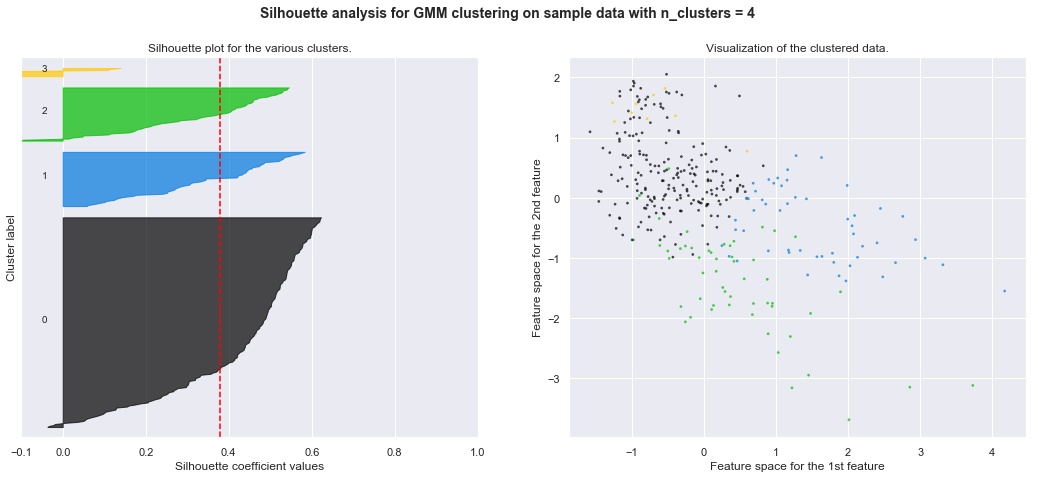

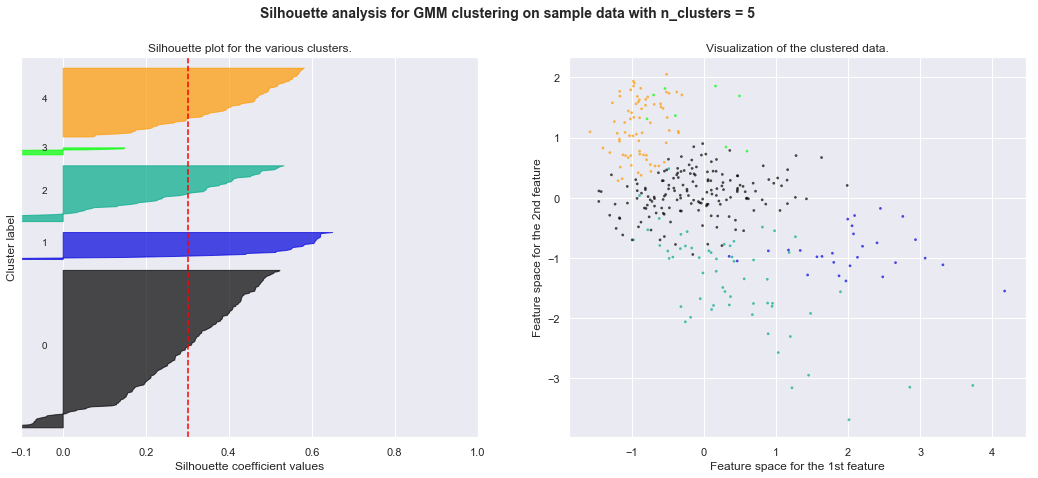

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture as GMM
Z= np.array(data[['Price','Year', 'Car']]).reshape(-1, 3)

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Z) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GMM(n_components=n_clusters, random_state=1,covariance_type ='diag')
    cluster_labels = clusterer.fit_predict(Z)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Z, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Z, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Z[:, 0], Z[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')


    ax2.set_title("Visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for GMM clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [19]:
X= subdf[['Lot Size','Year','SqFt','Distance','Price']]
data = pd.DataFrame(scale(X), columns=['Lot Size','Year','SqFt','Distance','Price'])
#gmm = GMM(n_components=4).fit(Z)
#labels = gmm.predict(Z)

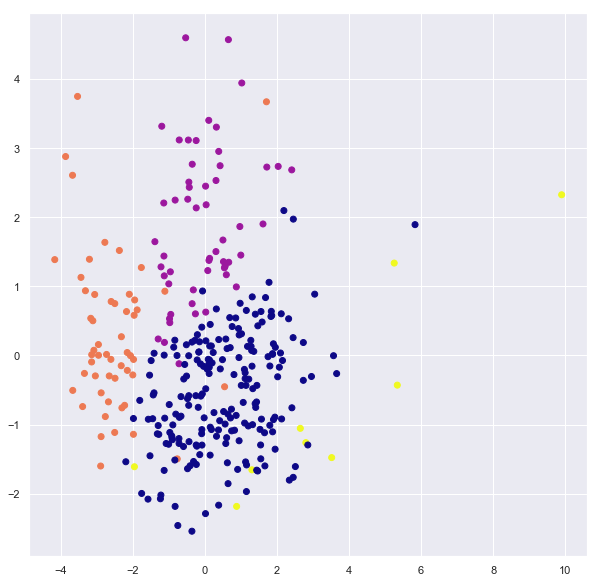

In [20]:
gmm = GMM(n_components=4, random_state=1, covariance_type='diag').fit(Z)
labels = gmm.predict(Z)
data['Cluster'] = pd.Series(labels)
plt.figure(figsize=(10,10))
plt.scatter(reduced_data['Dimension 1'],reduced_data['Dimension 2'], c=labels, cmap='plasma')  


#### Examining the size of your clusters is an oft-overlooked but critical part of cluster analysis:

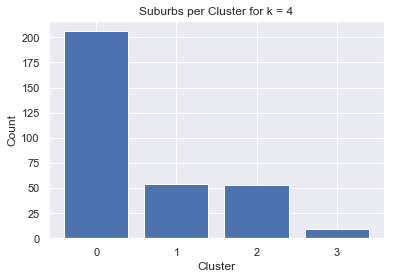

In [21]:
#clusters = KMeans(n_clusters = 3, random_state=1).fit(X)

counts = [0 for i in range(4)]
for i in range(4):
    for label in labels:
        if label == i:
            counts[i] += 1

plt.bar(range(4), counts)
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.xticks([0,1,2,3])
plt.title("Suburbs per Cluster for k = 4")
plt.show();

### Now that we have our clusters, let's examine relationships between the variables for each cluster.

In [22]:
X['Cluster']= labels

C:\Users\alehe\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


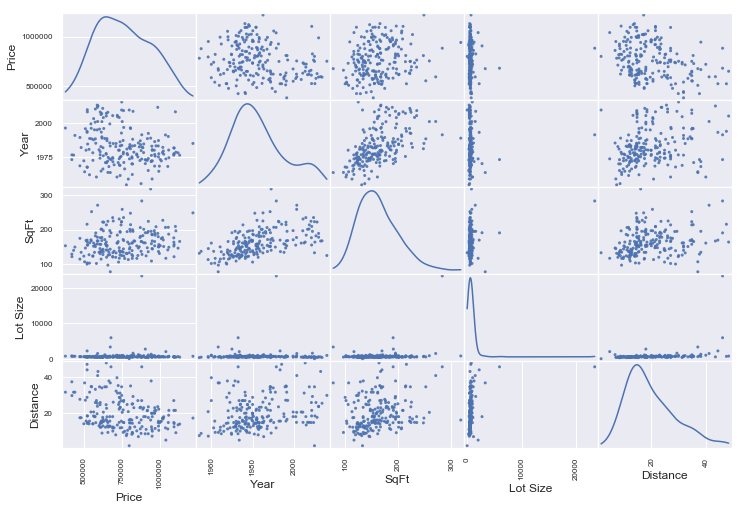

In [70]:
#plot the distribution of features for each cluster.
X0 = X[X['Cluster']==0]
pd.plotting.scatter_matrix(X0[['Price','Year', 'SqFt','Lot Size', 'Distance']], alpha = 0.9,figsize = (12,8), diagonal = 'kde');

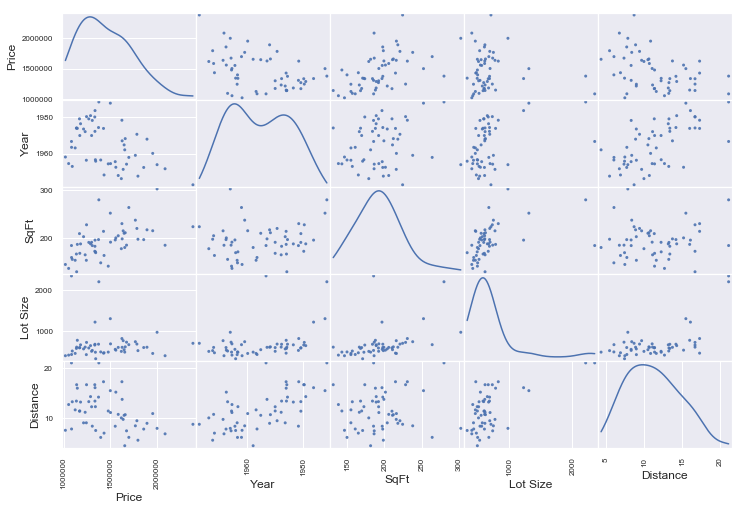

In [71]:
X1 = X[X['Cluster']==1]
pd.plotting.scatter_matrix(X1[['Price','Year', 'SqFt','Lot Size', 'Distance']], alpha = 0.9,figsize = (12,8), diagonal = 'kde');

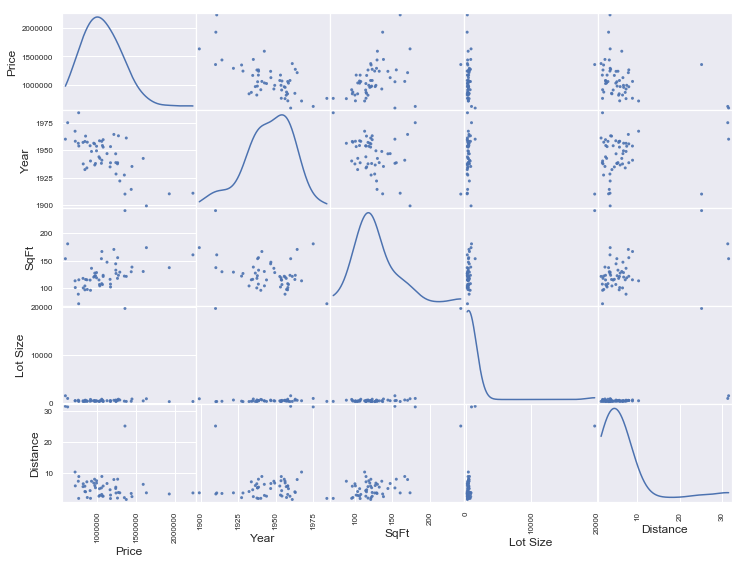

In [72]:
X2 = X[X['Cluster']==2]

pd.plotting.scatter_matrix(X2[['Price','Year', 'SqFt','Lot Size', 'Distance']], alpha = 0.9,figsize = (12,9), diagonal = 'kde');

In [23]:
#This helps to tell how much computing power was needed
print("Number of iterations to convergence: %f " %gmm.n_iter_)

Number of iterations to convergence: 11.000000 


In [46]:
from pandas import pivot_table
table = pivot_table(X,index=['Cluster'], aggfunc=np.mean)
table

,Distance,Lot Size,Price,SqFt,Year
Cluster,,,,,
0,19.891203,803.068291,7.631998e+05,162.590589,1982.929666
1,11.444527,679.309062,1.458575e+06,194.118203,1964.710908
2,6.189178,779.920932,1.093075e+06,125.804911,1945.214892
3,33.234357,5498.689553,6.882402e+05,179.835802,2003.161300


In [67]:
newdf = df.merge(X, on='Suburb', how='inner')
print(newdf.head())
table2 = pd.pivot_table(newdf, index=['Cluster', 'Type'],values=['Propertycount'],aggfunc='count')
table2

      Suburb             Address  Rooms Type    Price_x Method        SellerG  \
0  Glen Iris     1/58 Edgar St N      2    t   600000.0     VB           Gary   
1  Glen Iris  1/76 Summerhill Rd      3    t        NaN      S       Marshall   
2  Glen Iris       2/15 Scott Gr      3    t  1253000.0      S   Abercromby's   
3  Glen Iris        4/58 Bath Rd      2    u   671000.0      S           Noel   
4  Glen Iris       2/26 Edgar St      2    u        NaN     PN  hockingstuart   

        Date  Distance_x  Postcode   ...     YearBuilt  \
0 2016-08-22         9.2      3146   ...           NaN   
1 2016-06-04         9.2      3146   ...        2006.0   
2 2017-04-08         9.2      3146   ...        1995.0   
3 2017-03-04         9.2      3146   ...        1960.0   
4 2017-07-29         7.3      3146   ...        1960.0   

               CouncilArea             Regionname  Propertycount   Lot Size  \
0  Boroondara City Council  Southern Metropolitan        10412.0  563.60767   
1  Bor

Propertycount
Cluster Type               
0       h             11581
        t              1654
        u              1913
1       h              7031
        t              1128
        u              1799
2       h              5211
        t               787
        u              3487
3       h                41
        u                73

In [68]:
#See the housing types in each cluster.
newdf=newdf[['Cluster','Type', 'Price_x', 'YearBuilt']]
newdf.head()

,Cluster,Type,Price_x,YearBuilt
0,1,t,600000.0,NaN
1,1,t,NaN,2006.0
2,1,t,1253000.0,1995.0
3,1,u,671000.0,1960.0
4,1,u,NaN,1960.0


[]

<Figure size 1080x1080 with 0 Axes>

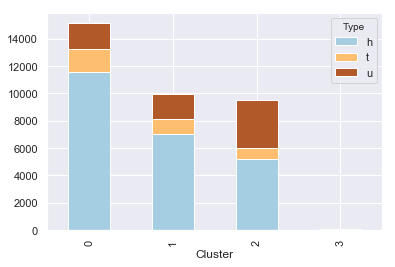

In [44]:
plt.figure(figsize=(15,15))
fig = pd.crosstab(newdf.Cluster, newdf.Type).plot(kind='bar',stacked=True, colormap='Paired')
plt.plot()

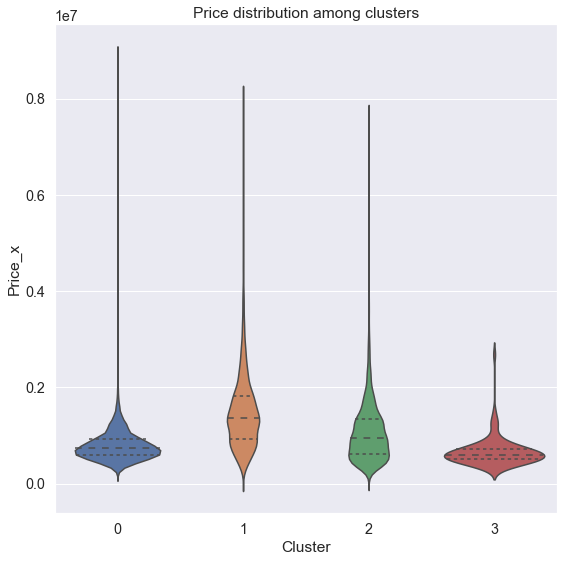

In [96]:
#Showing the price distribution among different housing types
plt.figure(figsize=(9,9))
sns.violinplot(x="Cluster", y="Price_x", data=newdf, inner='quartile')
plt.title("Price distribution among clusters")
plt.show()

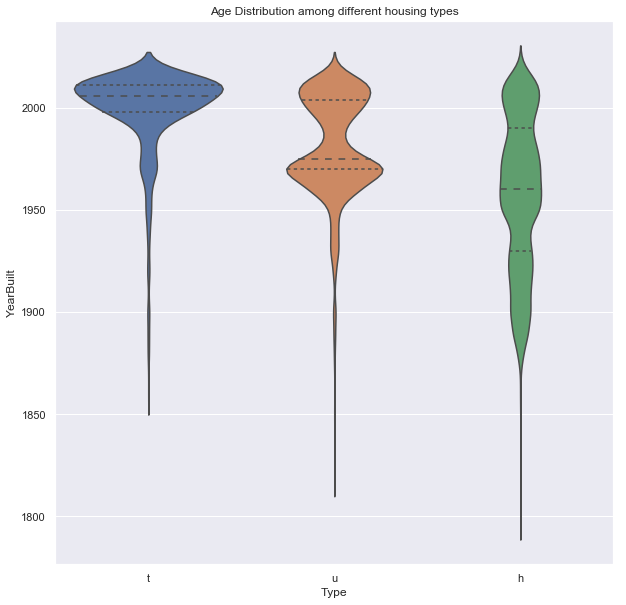

In [71]:
#Showing the age distribution among different housing types
plt.figure(figsize=(10,10))
sns.violinplot(x="Type", y="YearBuilt", data=newdf, inner='quartile')
plt.title("Age Distribution among different housing types")
plt.show()

## Analysis of Clusters:

Cluster 1 is overwhelmingly single-family detached housing. It's also the most affordable. Because of its longer distance from the city center, it appears to be semi-rural neighborhoods or what we'd call in America "exurbs". These are smaller, newer homes built on large lots. They probably contain more blue-collar families.

Cluster 2 is significantly closer to the city center and older than Cluster 1. It's majority single-family detached and appears to show a much more even mix of housing types, with the largest amount of "townhouse" units. I'm guessing this cluster shows what we call "inner-ring" suburbs in America. This mix appears to comprise the most desirable neighborhoods because this cluster 

Cluster 3 is the closest to the city center. It contains by far the oldest and smallest units, and exhibits the most even distribution of housing types. No data was available on age of the residents, but I'd assume this cluster contains many college students, young blue-collar workers living together or single, with an occasional luxury high-rise unit, or detached house in-town by the beach. Notably, some of the most expensive units in the dataset were luxury houses close to the city center

Cluster 4 only has 18 observations which are all single-family detached homes. These exhibit the features of rural, agricultural homes. The average lot size and house size is extremely large.

## Clustering Conclusions

It seems that the most valuable communities here have a mixture of apartments, houses and townhouses. It would probably be beneficial to a developer to build a mixture of housing types in a neighborhood.

In America, it's usually the case that older homes contain fewer bathrooms, but in Australia that doesn't seem to be the case. Bathroom did not show any linear trend with price or building age in my graphs above.

### Going forwar:
People could avoid bubbles by building this mix of housing *away* from the city center. It would take price pressure off the desirable units in town, and offer amenities to the residents of the more remote suburbs.

## K-Nearest Neighbors Experiment: Benchmark
I feel like KNN (in a regression setting) is the next logical step from PCA and Clustering, and an intermediary step between EDA and predictive machine learning. It tells us how good of a prediction we can make by just comparing an observation to its nearest neighbors in p-dimensional space (where p is the # of predictors).

In [76]:
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
df1=df[['YearBuilt','BuildingArea','Distance','Landsize','CouncilArea']]
df1= df1.dropna()
print(df1.describe())
print(len(df1.CouncilArea.unique()))
X = df1[['YearBuilt','BuildingArea','Distance','Landsize']]
y = df1['CouncilArea']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

          YearBuilt  BuildingArea      Distance      Landsize
count  11695.000000  11695.000000  11695.000000  11695.000000
mean    1963.723044    152.526718     11.017170    526.966652
std       37.323309     82.191183      6.822543   1014.932193
min     1800.000000      0.000000      0.000000      0.000000
25%     1940.000000    101.000000      6.300000    214.000000
50%     1970.000000    135.000000      9.900000    482.000000
75%     1999.000000    185.000000     13.900000    657.000000
max     2019.000000   1044.000000     48.100000  42800.000000
33


In [78]:
#Instantiate learning model (testing different amounts for k to get the best)
knn = KNC(n_neighbors=55)

#Fit the model
knn.fit(X_train, y_train)

#Predict the response
pred = knn.predict(X_test)

#Evaluate accuracy
print("Accuracy (F1) score:",accuracy_score(y_test, pred))

Accuracy (F1) score: 0.20854922279792745


## KNN Yielding a Poor Score: Interpretation

20% is obviously unacceptable for a machine learning model. Sometimes the "failure" of a certain model teaches you a lot, though. What I make of this, is that we have 31 different Council Areas and many have groups of similar houses. This is *reasonable.* 

Perhaps, instead of looking at how similar the observations are in a p-dimensional space we should *filter* the data through a series of criteria. This process is the "decision tree" classifier.

## Instead, try a decision tree model:

In [31]:
from sklearn.tree import DecisionTreeClassifier as DCT
X = df1[['YearBuilt','BuildingArea','Distance','Landsize']]
y=df1['CouncilArea']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = DCT(random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7227130236534626


## Wow, 72% accuracy *untuned.* What do we learn from the difference in scores?

Out of the box, XGBoost gets a 71% accuracy compared to KNN's 20% accuracy. So what does that tell us?

1. Boosted Trees is an extremely smart algorithm, and it's safe to assume with a little effort you could get 90% accuracy.
2. If we can take our data through a series of steps to narrow down the possibilities, classification accuracy immediately goes up. 
3. KNN yields a poor score because our data is *nuanced*. When you're trying to predict a neighborhood or urban area, the boundaries that define each area were arbitrarily drawn and have little "numerical" sense behind them. If we were trying to predict a feature that had more logical patterns, it's possible KNN would get better results.

## Now, let's try a boosted tree model, and tune it with GridSearch and Cross-Validation

I'll import GridSearchCV and feed it a dictionary of parameters to try. GridSearchCV will build a tree with every combination of these parameters, and chop my data up into 4 "folds" to train and test more exhaustively.

Then, I'll run my algorithm with only the best combination of parameters.

In [32]:
from xgboost import XGBClassifier as XGBC
X = df1[['YearBuilt','BuildingArea','Distance','Landsize']]
y=df1['CouncilArea']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = XGBC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7198632088914221


In [33]:
from sklearn.model_selection import GridSearchCV
params = {
 'max_depth':[4],
 'learning_rate':[0.15,0.2],
 'gamma':[0.5,0.75,1],
}

clf = GridSearchCV(model, param_grid=params, cv=4, verbose=3, scoring = 'f1_micro')
clf.fit(X_train,y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


C:\Users\alehe\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] gamma=0.5, learning_rate=0.15, max_depth=4 ......................
[CV]  gamma=0.5, learning_rate=0.15, max_depth=4, score=0.7569275644141954, total=  13.9s
[CV] gamma=0.5, learning_rate=0.15, max_depth=4 ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s


[CV]  gamma=0.5, learning_rate=0.15, max_depth=4, score=0.7625548512920528, total=  12.6s
[CV] gamma=0.5, learning_rate=0.15, max_depth=4 ......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.0s remaining:    0.0s


[CV]  gamma=0.5, learning_rate=0.15, max_depth=4, score=0.7601566324033284, total=  14.4s
[CV] gamma=0.5, learning_rate=0.15, max_depth=4 ......................
[CV]  gamma=0.5, learning_rate=0.15, max_depth=4, score=0.7538083538083538, total=  12.5s
[CV] gamma=0.5, learning_rate=0.2, max_depth=4 .......................
[CV]  gamma=0.5, learning_rate=0.2, max_depth=4, score=0.7617890131259115, total=  14.8s
[CV] gamma=0.5, learning_rate=0.2, max_depth=4 .......................
[CV]  gamma=0.5, learning_rate=0.2, max_depth=4, score=0.7713310580204779, total=  15.1s
[CV] gamma=0.5, learning_rate=0.2, max_depth=4 .......................
[CV]  gamma=0.5, learning_rate=0.2, max_depth=4, score=0.7684777288301519, total=  12.7s
[CV] gamma=0.5, learning_rate=0.2, max_depth=4 .......................
[CV]  gamma=0.5, learning_rate=0.2, max_depth=4, score=0.7611793611793611, total=  15.1s
[CV] gamma=0.75, learning_rate=0.15, max_depth=4 .....................
[CV]  gamma=0.75, learning_rate=0.15, 

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  6.6min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [4], 'learning_rate': [0.15, 0.2], 'gamma': [0.5, 0.75, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=3)

## Best score:
Best learning rates were with max depth 4, learning rate .5 and gamma=0.75
Got score of 76.94%.

For more detailed analysis, let's see how well each class was predicted using Scikit-Learn's classification_report function.

In [34]:
from sklearn.metrics import classification_report
model = XGBC(max_depth=4,gamma=0.75,learning_rate=0.15)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                                precision    recall  f1-score   support

          Banyule City Council       0.66      0.51      0.58       157
          Bayside City Council       0.79      0.72      0.76       154
       Boroondara City Council       0.72      0.79      0.75       369
         Brimbank City Council       0.76      0.70      0.73       154
        Cardinia Shire Council       1.00      0.50      0.67         6
            Casey City Council       1.00      0.75      0.86        16
          Darebin City Council       0.67      0.78      0.72       269
        Frankston City Council       0.82      1.00      0.90        33
        Glen Eira City Council       0.78      0.73      0.75       207
Greater Dandenong City Council       1.00      0.93      0.96        29
      Hobsons Bay City Council       0.64      0.58      0.61       108
             Hume City Council       0.87      0.81      0.84       154
         Kingston City Council       0.81      0.85      0.83  